# Determining if someone exercises or not...

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

from sqlalchemy import create_engine

import warnings
warnings.filterwarnings('ignore')

In [46]:
pd.set_option('display.max_rows', 3000)

In [47]:
# Importing the data into a dataframe

df = pd.read_csv('food_coded.csv')


In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 61 columns):
GPA                             123 non-null object
Gender                          125 non-null int64
breakfast                       125 non-null int64
calories_chicken                125 non-null int64
calories_day                    106 non-null float64
calories_scone                  124 non-null float64
coffee                          125 non-null int64
comfort_food                    124 non-null object
comfort_food_reasons            124 non-null object
comfort_food_reasons_coded      106 non-null float64
cook                            122 non-null float64
comfort_food_reasons_coded.1    125 non-null int64
cuisine                         108 non-null float64
diet_current                    124 non-null object
diet_current_coded              125 non-null int64
drink                           123 non-null float64
eating_changes                  122 non-null object
eating_chan

In [49]:
weight_df =  df[['income','Gender','cook','employment','exercise','father_education','nutritional_check','sports','vitamins','weight','mother_education']]

weight_df.head()


,income,Gender,cook,employment,exercise,father_education,nutritional_check,sports,vitamins,weight,mother_education
0,5.0,2,2.0,3.0,1.0,5.0,5,1.0,1,187,1.0
1,4.0,1,3.0,2.0,1.0,2.0,4,1.0,2,155,4.0
2,6.0,1,1.0,3.0,2.0,2.0,4,2.0,1,I'm not answering this.,2.0
3,6.0,1,2.0,3.0,3.0,2.0,2,2.0,1,"Not sure, 240",4.0
4,6.0,1,1.0,2.0,1.0,4.0,3,1.0,2,190,5.0


In [50]:
weight_df.isnull().sum()

income                1
Gender                0
cook                  3
employment            9
exercise             13
father_education      1
nutritional_check     0
sports                2
vitamins              0
weight                2
mother_education      3
dtype: int64

In [51]:
weight_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 11 columns):
income               124 non-null float64
Gender               125 non-null int64
cook                 122 non-null float64
employment           116 non-null float64
exercise             112 non-null float64
father_education     124 non-null float64
nutritional_check    125 non-null int64
sports               123 non-null float64
vitamins             125 non-null int64
weight               123 non-null object
mother_education     122 non-null float64
dtypes: float64(7), int64(3), object(1)
memory usage: 10.8+ KB


In [52]:
# checking to see which columns do not have numerical values

weight_df_null = weight_df.isnull().sum()*100/weight_df.isnull().count()
weight_df_null.sort_values()


Gender                0.0
nutritional_check     0.0
vitamins              0.0
income                0.8
father_education      0.8
sports                1.6
weight                1.6
cook                  2.4
mother_education      2.4
employment            7.2
exercise             10.4
dtype: float64

In [53]:
#formatting columns

new_exercise_column = pd.DataFrame(weight_df['exercise'].fillna(weight_df['exercise'].mean(),inplace=False))
new_exercise_column = np.round(new_exercise_column, decimals=0)




weight_df = weight_df.drop('exercise', axis=1)
weight_df.insert(2,'exercise',new_exercise_column, True)




In [54]:
#formatting columns


new_employment_column    = pd.DataFrame(weight_df['employment'].fillna(weight_df['employment'].mean(),inplace=False))
new_income_column        = pd.DataFrame(weight_df['income'].fillna(weight_df['income'].mean(),inplace=False))
new_sports_column        = pd.DataFrame(weight_df['sports'].fillna(weight_df['sports'].mean(),inplace=False))
new_cook_column          = pd.DataFrame(weight_df['cook'].fillna(weight_df['cook'].mean(),inplace=False))

new_employment_column = np.round(new_employment_column, decimals=1)
new_income_column = np.round(new_income_column, decimals=1)
new_sports_column = np.round(new_sports_column, decimals=1)
new_cook_column  = np.round(new_cook_column, decimals=1)

weight_df = weight_df.drop('employment', axis=1)
weight_df = weight_df.drop('income', axis=1)
weight_df = weight_df.drop('sports', axis=1)
weight_df = weight_df.drop('cook', axis=1)

weight_df.insert(5,'employment',new_employment_column, True)
weight_df.insert(6,'income',new_income_column, True)
weight_df.insert(8,'sports',new_sports_column, True)
weight_df.insert(3,'cook',new_cook_column,True )


weight_df.update(weight_df.replace('Not sure, 240',240, inplace=False))
weight_df.update(weight_df.replace('144 lbs',144, inplace=False))

weight_df['weight'] = weight_df['weight'].drop([2], inplace=False)





In [55]:
weight_df.head()

,Gender,exercise,father_education,cook,nutritional_check,vitamins,employment,income,weight,sports,mother_education
0,2,1.0,5.0,2.0,5,1,3.0,5.0,187,1.0,1.0
1,1,1.0,2.0,3.0,4,2,2.0,4.0,155,1.0,4.0
2,1,2.0,2.0,1.0,4,1,3.0,6.0,NaN,2.0,2.0
3,1,3.0,2.0,2.0,2,1,3.0,6.0,240,2.0,4.0
4,1,1.0,4.0,1.0,3,2,2.0,6.0,190,1.0,5.0


In [56]:
#formatting columns

new_weight_column = weight_df['weight'].fillna(0)

weight_df['weight'].update(new_weight_column)

weight_df["weight"] = weight_df["weight"].astype(int)

last_updated_weight = weight_df['weight'].replace(0, weight_df['weight'].mean(), inplace=False )

weight_df['weight'].update(last_updated_weight)


In [57]:
weight_df.dropna(inplace=True)
weight_df.isnull().sum()

Gender               0
exercise             0
father_education     0
cook                 0
nutritional_check    0
vitamins             0
employment           0
income               0
weight               0
sports               0
mother_education     0
dtype: int64

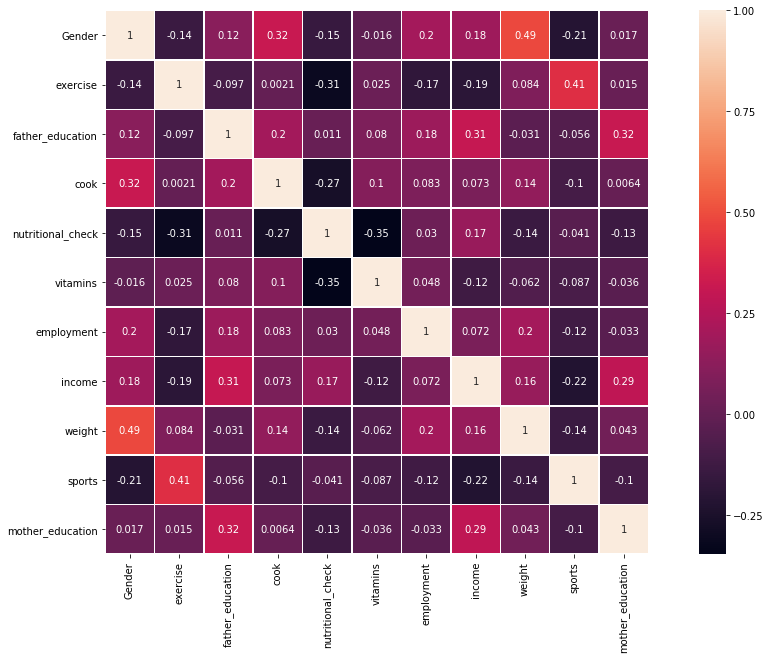

In [58]:
weight_corr = weight_df.corr()

plt.figure(figsize=(18,10))

sns.heatmap(weight_corr,square=True,annot=True,linewidth=.5)
plt.show()

In [59]:
weight_df.head()

,Gender,exercise,father_education,cook,nutritional_check,vitamins,employment,income,weight,sports,mother_education
0,2,1.0,5.0,2.0,5,1,3.0,5.0,187.000,1.0,1.0
1,1,1.0,2.0,3.0,4,2,2.0,4.0,155.000,1.0,4.0
2,1,2.0,2.0,1.0,4,1,3.0,6.0,155.232,2.0,2.0
3,1,3.0,2.0,2.0,2,1,3.0,6.0,240.000,2.0,4.0
4,1,1.0,4.0,1.0,3,2,2.0,6.0,190.000,1.0,5.0


In [60]:
X = weight_df.iloc[:,1:]
Y = weight_df.iloc[:,0]


.

.

# Target variable ==> EXERCISE

In [61]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state=25)

.

.

.

#  Trial 1

In [63]:
weight_df = weight_df.reindex(columns=['exercise','father_education','cook','nutritional_check','vitamins','employment','income','weight','sports','mother_education'])

In [64]:
X = weight_df.iloc[:,1:]
Y = weight_df.iloc[:,0]

In [67]:
X_train.head()

,const,exercise,father_education,cook,nutritional_check,vitamins,employment,income,weight,sports,mother_education
82,1.0,1.0,4.0,2.8,3,2,3.0,3.0,170.0,1.0,4.0
78,1.0,1.0,2.0,2.0,4,1,2.0,5.0,135.0,1.0,2.0
99,1.0,2.0,3.0,4.0,2,1,2.0,4.0,165.0,1.0,4.0
90,1.0,1.0,2.0,4.0,2,1,3.0,6.0,260.0,1.0,3.0
60,1.0,1.0,4.0,2.0,4,1,3.0,6.0,135.0,1.0,4.0


In [68]:
X_train = sm.add_constant(X_train)

In [69]:
results = sm.OLS(Y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                 Gender   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.351
Method:                 Least Squares   F-statistic:                     5.487
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           4.92e-06
Time:                        02:03:02   Log-Likelihood:                -34.972
No. Observations:                  84   AIC:                             91.94
Df Residuals:                      73   BIC:                             118.7
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.3557      0.47

In [70]:
LogReg = LogisticRegression()
LogReg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [71]:
LogReg.score(X_train, Y_train)

0.8095238095238095

.

.

In [72]:
# LogReg = LogisticRegression()
# LogReg.fit(X, Y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [73]:
# LogReg.score(X, Y)

0.6776859504132231

.

.

.

# Trial 2

In [74]:
weight_df = weight_df.reindex(columns=['exercise','nutritional_check','employment','weight','sports'])

In [75]:
X = weight_df.iloc[:,1:]
Y = weight_df.iloc[:,0]

In [76]:
weight_df.head()

,exercise,nutritional_check,employment,weight,sports
0,1.0,5,3.0,187.000,1.0
1,1.0,4,2.0,155.000,1.0
2,2.0,4,3.0,155.232,2.0
3,3.0,2,3.0,240.000,2.0
4,1.0,3,2.0,190.000,1.0


In [77]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state=25)

In [78]:
X_train.head()

,nutritional_check,employment,weight,sports
82,3,3.0,170.0,1.0
78,4,2.0,135.0,1.0
99,2,2.0,165.0,1.0
90,2,3.0,260.0,1.0
60,4,3.0,135.0,1.0


In [79]:
X_train = sm.add_constant(X_train)

In [80]:
results = sm.OLS(Y_train, X_train).fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               exercise   R-squared:                       0.310
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     8.884
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           5.63e-06
Time:                        02:06:43   Log-Likelihood:                -69.784
No. Observations:                  84   AIC:                             149.6
Df Residuals:                      79   BIC:                             161.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.3741      0.49

In [82]:
LogReg = LogisticRegression()
LogReg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

.

.

.

# Trial 3 ( using interaction variables  )

In [90]:
Y = weight_df.iloc[:,0]


# INTERACTION VARIABLE

weight_df['employed_works'] = weight_df.employment * weight_df.sports



weight_df.reindex(columns=['exercise','nutritional_check','employment','weight','sports','employed_works'])

X = weight_df.iloc[:,1:]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .3, random_state=25)

print("The number of observations in the training set is {}".format(X_train.shape[0]))
print("The number of observations in the test set is {}".format(X_test.shape[0]),"\n")

X_train = sm.add_constant(X_train)

results = sm.OLS(Y_train, X_train).fit()

print(results.summary())

The number of observations in the training set is 84
The number of observations in the test set is 37 

                            OLS Regression Results                            
Dep. Variable:               exercise   R-squared:                       0.313
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     7.101
Date:                Sun, 21 Jun 2020   Prob (F-statistic):           1.61e-05
Time:                        02:24:24   Log-Likelihood:                -69.630
No. Observations:                  84   AIC:                             151.3
Df Residuals:                      78   BIC:                             165.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------

In [91]:
LogReg = LogisticRegression()
LogReg.fit(X_train, Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [92]:
LogReg.score(X_train, Y_train)

0.6428571428571429

# Conclusion:

The model proved to be untrustworthy with Adjusted R-squared figures so low. The percentages of the three Adjusted R-squared 
was 30%. The interesting discovery was the Accuracy score was around 81%.  Overall, since the Adjusted R-squred is the most important determinant, therefore the model is not reliable in predicting how often an individual exercises.